In [531]:
import pandas as pd
import numpy as np
import scipy as sp
import glob as glob
from datetime import datetime
import time

def subset_permute(n_subset, n_total):
    #An effort to make a random list of range of integers as even as possible.
    #i.e., np.random.randint() gave quite variable results. 
    np.random.seed()
    pm = np.tile ( np.arange(n_subset),  int(np.ceil(n_total/n_subset))) [0:n_total] #[1,2,3,4,5,1,2,3,4 ... 1,2]
    for i in range(20):
        np.random.shuffle(pm) #Shuffle somewhat evenly distributed array. 
    return pm

# def parse_datetime2(raw_datetime):
#     datetime_temp = str.split(raw_datetime, ' ')

#     if len(datetime_temp)<2:
#         return np.nan, np.nan, np.nan, 365, np.nan

#     date_temp = str.split(datetime_temp[0],'/')
#     yy = int(date_temp[2])
#     mm = int(date_temp[0])
#     dd = int(date_temp[1])

#     time_temp = str.split(datetime_temp[1],':')
#     hh = int(time_temp[0])
#     mn = int(time_temp[1])

#     datetime_obj = datetime(yy,mm,dd,hh,mn)

#     weekday = datetime_obj.weekday()
#     if 8<= hh and hh < 12:
#         timeofday = 'AM'
#     elif 12 <= hh and hh <= 17: 
#         timeofday = 'PM'
#     else: 
#         timeofday = 'OFF'
#     return weekday, timeofday, mm, datetime_obj.timetuple().tm_yday, datetime_obj

# def parse_datetime(raw_datetime):
#     if len(raw_datetime)<5:
#         return np.array([np.nan, 365, np.nan]), np.nan    
#     datetime_obj = datetime.strptime(rd,'%m/%d/%Y %H:%M')
#     #return datetime_obj.weekday(), datetime_obj.timetuple().tm_yday, datetime_obj.hour, datetime_obj
#     return np.array([datetime_obj.weekday(), datetime_obj.timetuple().tm_yday, datetime_obj.hour]), datetime_obj


def parse_datetime(raw_datetime):
    if len(raw_datetime)<5:
        return np.nan, 365, np.nan, np.nan    
    datetime_obj = datetime.strptime(raw_datetime,'%m/%d/%Y %H:%M')
    return datetime_obj.weekday(), datetime_obj.timetuple().tm_yday, datetime_obj.hour, datetime_obj


def bizhour(hh):
    biz = ['OFF','AM','PM','OFF']
    breakpoints = [8, 12, 17]
    return biz[bisect(breakpoints, hh)]

def get_descr_bizhour(hhmat):
    return np.array(list(map(bizhour, hhmat)))

def parse_weather(weatherfilename, featurelist):
    dummylines=2
    i=0
    count = 0
    weatherlist = [[] for i in range(len(featurelist))]

    with open(weatherfilename) as f:
        for l in f.readlines():        
            if count > 0:
                if dummylines:
                    dummylines-=1
                    continue
                count-=1
                weatherlist[i-1] += [float(j) for j in l.split()[1:-1]]
            else:
                if i >= len(featurelist):
                    break
                if featurelist[i] in l:
                    i+=1
                    count = 12
                    dummylines = 2
    df = pd.DataFrame(np.array(weatherlist).T,columns=featurelist)
    narray = np.array([[np.nan], [np.nan], [np.nan], [np.nan]]).T
    df=df.append(pd.DataFrame(narray, columns=featurelist),ignore_index=True)
    #df2 = pd.concat([df.loc[:59], pd.DataFrame(df.iloc[59]).transpose(), df.loc[60:]],axis=0)
    return df

def query_weather(doy, weatherdf):
    return weatherdf.iloc[doy-1].reset_index(drop=True)

# def query_weather2(month, day):
#     #https://www.ncdc.noaa.gov/cgi-bin/climatenormals/climatenormals.pl?directive=prod_select2&prodtype=CLIM8101&subrnum=
#     if np.isnan(month) or np.isnan(day):
#         return np.nan, np.nan, np.nan, np.nan
#     WeatherFile ='CA045115.xlsx'
#     MnT = pd.read_excel(WeatherFile,sheetname='MinTemp')
#     MxT = pd.read_excel(WeatherFile,sheetname='MaxTemp')
#     AvgT = pd.read_excel(WeatherFile,sheetname='AvgTemp')
#     Prcp = pd.read_excel(WeatherFile,sheetname='Precipitation')
    
#     return MnT.iloc[month-1, day-1], MxT.iloc[month-1, day-1], AvgT.iloc[month-1, day-1], Prcp.iloc[month-1, day-1]

def get_label(cancel_list, valid_reason):
    ct = cancel_list.value_counts()

    labels = np.zeros(cancel_list.shape)
    toinclude = np.array(valid_reason)
    for reason in toinclude: 
        labels += cancel_list ==reason
    labels=(labels>0).astype(int) #Cancel == 1
    return labels


In [529]:
a=time.time()

data_raw_fname = 'be223a_dataset.csv'
data_raw = pd.read_csv(data_raw_fname)

raw_datetime = data_raw['ScheduledDTTM_D']
    


num_samples = raw_datetime.shape[0]

weekday = np.zeros(num_samples)
timeofday = np.zeros(num_samples)
ddofyr = np.zeros(num_samples)
dtobjs = np.zeros(num_samples, dtype=object)
tdata = np.zeros([num_samples,3])


featurelist = ['Minimum Temperature', 'Maximum Temperature', 'Average Temperature', 'Precipitation']



for i,rd in enumerate(data_raw['ScheduledDTTM_D']):
    weekday[i],ddofyr[i],timeofday[i], dtobjs[i]=parse_datetime2(rd)
    #tdata[i,:], dtobjs[i]=parse_datetime(rd)
    

weathermaster = parse_weather('CA045115.txt', featurelist)
weatherdf = query_weather(ddofyr,weathermaster)
bizdescr = get_descr_bizhour(timeofday)


label = get_label(data_raw['ReasonDesc'], ['CANCELLED BY PT', 'PT NO SHOW'])
features = pd.concat([
    data_raw[['Gender','Age','OrgCode','Modality','Anatomy','SubSpecialty']],
    pd.DataFrame({'Weekday':weekday, 'Timeofday':bizdescr,'Datetime Obj':dtobjs,'Label':label}),
    weatherdf
                     ],axis=1)


print(time.time()-a)    

# features = features[['Gender','Age','OrgCode','Modality','Anatomy','SubSpecialty',
#                      'Weekday','Timeofday','MinTemp','MaxTemp','AvgTemp','Precip','Label']]

#features.to_csv('features_raw2.csv')
#features_encoded=pd.get_dummies(features)
#features_encoded.to_csv('features_encoded2.csv')





3.029179096221924


In [530]:
features

,Gender,Age,OrgCode,Modality,Anatomy,SubSpecialty,Datetime Obj,Label,Timeofday,Weekday,Minimum Temperature,Maximum Temperature,Average Temperature,Precipitation
0,F,85,SMWG,US,LWREXT,US,3246-11-27 13:00:00,0,PM,1.0,50.0,71.0,61.0,4.0
1,F,31,MP,CR,CHEST,CHEST,3246-11-01 14:10:00,0,PM,3.0,56.0,76.0,66.0,2.0
2,F,61,SMWG,MG,LTBREAST,BREAST,NaN,0,OFF,NaN,48.0,68.0,58.0,8.0
3,F,68,SMWG,MG,BREAST,BREAST,3246-12-06 09:40:00,0,AM,3.0,49.0,70.0,59.0,5.0
4,F,68,SMWG,MG,BREAST,BREAST,3246-12-06 09:45:00,0,AM,3.0,49.0,70.0,59.0,5.0
5,F,64,SMWG,MG,BREAST,BREAST,3247-03-12 10:50:00,0,AM,1.0,51.0,69.0,60.0,11.0
6,F,21,SMO,CR,HANDS,MUSCL,3246-11-15 17:00:00,0,OFF,3.0,53.0,73.0,63.0,4.0
7,M,39,RICP,CR,FOREARM,MUSCL,3246-01-06 00:00:00,0,OFF,5.0,48.0,68.0,58.0,9.0
8,F,69,MP,MR,BRAIN,NEURO,NaN,0,OFF,NaN,48.0,68.0,58.0,8.0
9,F,33,MP1,MR,BRAIN,HEAD_NECK,3246-11-08 12:00:00,0,PM,3.0,54.0,75.0,64.0,3.0


In [210]:
data_raw_fname = 'be223a_dataset.csv'
data_raw = pd.read_csv(data_raw_fname)

cancel_list = data_raw['ReasonDesc']
#ct = labels.groupby(labels).count()
ct = cancel_list.value_counts()

labels = np.zeros(cancel_list.shape)
toinclude = np.array(['CANCELLED BY PT', 'PT NO SHOW'])
for reason in toinclude: 
    labels += cancel_list ==reason
labels=(labels>0).astype(int) #Cancel == 1

features_encoded = pd.read_csv('features_encoded.csv')
features_encoded=features_encoded.rename(columns={features_encoded.columns[0]:'orig_index'})
features_encoded = pd.concat([features_encoded,pd.DataFrame({'Labels':labels})], axis=1)
show=features_encoded[features_encoded['Labels']==0]
noshow=features_encoded[features_encoded['Labels']==1]

show_subset = show.iloc[np.random.choice(show.shape[0],noshow.shape[0],replace=False)] #Balancing the numbers
features_final=pd.concat([noshow, show_subset],axis=0)
features_final=features_final.reset_index(drop=True)

n_fold = 5
foldlist = subset_permute(n_fold,features_final.shape[0]) #List of fold numbers
features_final = pd.concat([features_final,pd.DataFrame({'Folds':foldlist})], axis=1)
features_final = pd.concat([features_final.iloc[:,1:], features_final.iloc[:,0]],axis=1)
display(features_final)
features_final.to_csv('features_encoded_processed.csv',index=False)


FileNotFoundError: File b'features_encoded.csv' does not exist

In [11]:
data_raw_fname = 'be223a_dataset.csv'
data_raw = pd.read_csv(data_raw_fname)

ICD_list = data_raw['icd9']
ICD_ct = ICD_list.groupby(ICD_list).count()
print(ICD_ct)
ICD_ct2= ICD_list.value_counts()
print(ICD_ct2)


icd9
011.90|                           4
011.90|440.0|                     1
011.90|V45.01|795.51|             1
018.90|                           2
038.9|                            1
038.9|453.6|                      1
038.9|486|995.91|                 1
038.9|518.0|                      2
038.9|518.0|514|                  1
038.9|518.0|780.60|               1
038.9|518.0|793.19|               5
038.9|518.0|799.02|               2
038.9|518.0|V58.81|               1
038.9|518.0|V58.81|514|           1
038.9|518.0|V58.81|793.19|        1
038.9|518.0|V58.81|995.91|        2
038.9|518.0|V58.82|514|           1
038.9|586|995.91|                 2
038.9|749.20|995.91|              1
038.9|959.12|959.19|              1
038.9|995.91|                    14
038.9|995.91|780.60|              1
038.9|995.91|780.97|              1
038.9|995.91|793.19|              3
038.9|995.91|959.11|793.19|       1
038.9|995.91|V58.44|              1
038.9|V12.54|348.89|              1
038.9|V42.7|998.12|453.

In [30]:
import sys
sys.path.append('./icd9_copy')

from icd9 import ICD9
tr=ICD9('codes.json')
b=tr.find('V76.12')
print(b.descr)

print(tr.find('V58.81').descr)

print(tr.find('001').descr)
#print(tr.find('793').children[0])
# for ch in tr.find('793').leaves:
#     print(ch.code, ch.descr)


#print(tr.code('Cholera'))

Other screening mammogram
Fitting and adjustment of vascular catheter
Cholera


In [166]:
import pandas as pd

featurelist = ['Minimum Temperature', 'Maximum Temperature', 'Average Temperature', 'Precipitation']
dummylines = 2
i=0
count = 0
weatherlist = [[] for i in range(len(featurelist))]

with open('CA045115.txt') as f:
    for l in f.readlines():        
        if count > 0:
            if dummylines:
                dummylines-=1
                continue
            count-=1
            weatherlist[i-1] += [float(j) for j in l.split()[1:-1]]
        else:
            if i >= len(featurelist):
                break
            if featurelist[i] in l:
                i+=1
                count = 12
                dummylines = 2
df = pd.DataFrame(np.array(weatherlist).T,columns=featurelist)     
df
#df2 = pd.concat([df.loc[:59], pd.DataFrame(df.iloc[59]).transpose(), df.loc[60:]],axis=0)
#df2.head(70)

,Minimum Temperature,Maximum Temperature,Average Temperature,Precipitation
0,48.0,68.0,58.0,8.0
1,48.0,68.0,58.0,9.0
2,48.0,68.0,58.0,9.0
3,48.0,68.0,58.0,9.0
4,48.0,68.0,58.0,9.0
5,48.0,68.0,58.0,9.0
6,48.0,68.0,58.0,9.0
7,48.0,68.0,58.0,10.0
8,48.0,68.0,58.0,10.0
9,48.0,68.0,58.0,10.0


In [167]:
df.iloc[[1,4,6]]

,Minimum Temperature,Maximum Temperature,Average Temperature,Precipitation
1,48.0,68.0,58.0,9.0
4,48.0,68.0,58.0,9.0
6,48.0,68.0,58.0,9.0


In [134]:
a,b,c,d,e=parse_datetime('1/1/2016 1:00:00 PM')
e

datetime.datetime(2016, 1, 1, 1, 0)

In [135]:
e.timetuple().tm_yday

1

In [127]:
print(data_raw['ScheduledDTTM_D'].head()[0])
parse_datetime(data_raw['ScheduledDTTM_D'].head()[0])

11/27/3246 13:00


(1, 'PM', 11, 27, datetime.datetime(3246, 11, 27, 13, 0))

In [202]:
#df.append

narray = np.array([[np.nan], [np.nan], [np.nan], [np.nan]]).T
df.append(pd.DataFrame(narray, columns=featurelist),ignore_index=True)


#, columns=featurelist

,Minimum Temperature,Maximum Temperature,Average Temperature,Precipitation
0,48.0,68.0,58.0,8.0
1,48.0,68.0,58.0,9.0
2,48.0,68.0,58.0,9.0
3,48.0,68.0,58.0,9.0
4,48.0,68.0,58.0,9.0
5,48.0,68.0,58.0,9.0
6,48.0,68.0,58.0,9.0
7,48.0,68.0,58.0,10.0
8,48.0,68.0,58.0,10.0
9,48.0,68.0,58.0,10.0


In [204]:
df

,Minimum Temperature,Maximum Temperature,Average Temperature,Precipitation
0,48.0,68.0,58.0,8.0
1,48.0,68.0,58.0,9.0
2,48.0,68.0,58.0,9.0
3,48.0,68.0,58.0,9.0
4,48.0,68.0,58.0,9.0
5,48.0,68.0,58.0,9.0
6,48.0,68.0,58.0,9.0
7,48.0,68.0,58.0,10.0
8,48.0,68.0,58.0,10.0
9,48.0,68.0,58.0,10.0


In [209]:
df=df.append(pd.DataFrame(narray, columns=featurelist),ignore_index=True)
df.iloc[365].as_matrix()[0]


nan

In [233]:
from datetime import datetime

datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

datetime.datetime(2005, 6, 1, 13, 33)

In [238]:
print(rd)
datetime_obj = datetime.strptime(rd,'%m/%d/%Y %H:%M')
print(datetime_obj)


1/7/3247 14:50
3247-01-07 14:50:00


In [242]:
import bisect 

p=np.array([3,9,13,19])
bisect.bisect_left([8,12,17],3)

0

In [252]:
grades = "FEDCBA"
breakpoints = [30, 44, 66, 75, 85]
from bisect import bisect
def grade(total):
    return grades[bisect(breakpoints, total)]

print(grade(66))
print(np.array(list(map(grade, [33, 99, 77, 44, 12, 88]))))

C
['E' 'A' 'B' 'D' 'F' 'A']


In [336]:
biz = ['OFF','AM','PM','OFF']
breakpoints = [8, 12, 17]
def bizhour(hh):
    return biz[bisect(breakpoints, hh)]


#times = np.array([3, 9, 11, 13, 19])
a = time.time()
times = np.random.randint(0,24,100)
print(np.array(list(map(bizhour, times))))
print(time.time()-a)

a = time.time()
tmat=[]
tmat2=[]

for tt in times:
    tmat2 = np.append(tmat2,tt)
    tmat=np.append(tmat,bizhour(tt))
print(tmat)
print(time.time()-a)
    
a = time.time()
tmat=[]
tmat2=[]

for tt in times:
    tmat2 = np.append(tmat2,tt)
print(np.array(list(map(bizhour, tmat2))))
print(time.time()-a)
    

    
print(tmat2)


['OFF' 'AM' 'AM' 'PM' 'AM' 'AM' 'OFF' 'OFF' 'OFF' 'AM' 'OFF' 'OFF' 'OFF'
 'OFF' 'PM' 'PM' 'OFF' 'OFF' 'OFF' 'OFF' 'AM' 'PM' 'OFF' 'OFF' 'PM' 'OFF'
 'PM' 'OFF' 'OFF' 'PM' 'PM' 'OFF' 'PM' 'AM' 'PM' 'OFF' 'OFF' 'AM' 'OFF'
 'OFF' 'OFF' 'AM' 'PM' 'PM' 'PM' 'AM' 'OFF' 'PM' 'OFF' 'OFF' 'OFF' 'PM'
 'OFF' 'AM' 'OFF' 'OFF' 'OFF' 'AM' 'OFF' 'OFF' 'PM' 'OFF' 'OFF' 'OFF' 'OFF'
 'AM' 'AM' 'PM' 'OFF' 'OFF' 'OFF' 'PM' 'OFF' 'OFF' 'OFF' 'OFF' 'OFF' 'PM'
 'OFF' 'OFF' 'OFF' 'AM' 'PM' 'OFF' 'OFF' 'OFF' 'OFF' 'AM' 'PM' 'PM' 'PM'
 'PM' 'PM' 'OFF' 'PM' 'OFF' 'OFF' 'AM' 'PM' 'OFF']
0.0006132125854492188
['OFF' 'AM' 'AM' 'PM' 'AM' 'AM' 'OFF' 'OFF' 'OFF' 'AM' 'OFF' 'OFF' 'OFF'
 'OFF' 'PM' 'PM' 'OFF' 'OFF' 'OFF' 'OFF' 'AM' 'PM' 'OFF' 'OFF' 'PM' 'OFF'
 'PM' 'OFF' 'OFF' 'PM' 'PM' 'OFF' 'PM' 'AM' 'PM' 'OFF' 'OFF' 'AM' 'OFF'
 'OFF' 'OFF' 'AM' 'PM' 'PM' 'PM' 'AM' 'OFF' 'PM' 'OFF' 'OFF' 'OFF' 'PM'
 'OFF' 'AM' 'OFF' 'OFF' 'OFF' 'AM' 'OFF' 'OFF' 'PM' 'OFF' 'OFF' 'OFF' 'OFF'
 'AM' 'AM' 'PM' 'OFF' 'OFF' 'OFF' 'PM' 'OFF' '

In [259]:
np.random.randint(0,24,10)

array([11,  4,  8, 16, 10, 18, 10,  6, 10,  2])

In [320]:

print(datetime_obj)
b=pd.DataFrame([datetime_obj,datetime_obj],columns=['hi'])
display(b)
print(b['hi'].get_values()[1].weekday())

3247-01-07 14:50:00


,hi
0,3247-01-07 14:50:00
1,3247-01-07 14:50:00


0


In [328]:
datetime_obj.hour

14

In [333]:
print(rd)
a,b,c,d=parse_datetime(rd)
print(a,b,c,d)


1/7/3247 14:50
0 7 14 3247-01-07 14:50:00


In [340]:
print(get_descr_bizhour(times))

['OFF' 'AM' 'AM' 'PM' 'AM' 'AM' 'OFF' 'OFF' 'OFF' 'AM' 'OFF' 'OFF' 'OFF'
 'OFF' 'PM' 'PM' 'OFF' 'OFF' 'OFF' 'OFF' 'AM' 'PM' 'OFF' 'OFF' 'PM' 'OFF'
 'PM' 'OFF' 'OFF' 'PM' 'PM' 'OFF' 'PM' 'AM' 'PM' 'OFF' 'OFF' 'AM' 'OFF'
 'OFF' 'OFF' 'AM' 'PM' 'PM' 'PM' 'AM' 'OFF' 'PM' 'OFF' 'OFF' 'OFF' 'PM'
 'OFF' 'AM' 'OFF' 'OFF' 'OFF' 'AM' 'OFF' 'OFF' 'PM' 'OFF' 'OFF' 'OFF' 'OFF'
 'AM' 'AM' 'PM' 'OFF' 'OFF' 'OFF' 'PM' 'OFF' 'OFF' 'OFF' 'OFF' 'OFF' 'PM'
 'OFF' 'OFF' 'OFF' 'AM' 'PM' 'OFF' 'OFF' 'OFF' 'OFF' 'AM' 'PM' 'PM' 'PM'
 'PM' 'PM' 'OFF' 'PM' 'OFF' 'OFF' 'AM' 'PM' 'OFF']


In [345]:
b=np.zeros(1)
b[0]=1
b[1]=2

IndexError: index 1 is out of bounds for axis 0 with size 1

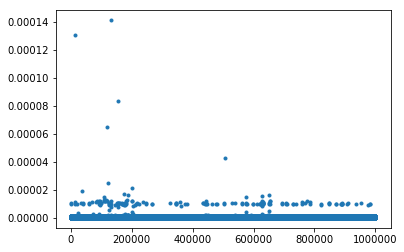

In [432]:
import matplotlib.pyplot as plt
n = 1000000
a = np.zeros(n)
for i in range(0,n):
    bb = time.time()
    a[i]=time.time()-bb
    
plt.figure()
plt.plot(a,'.')
plt.show()

In [494]:
ss = np.zeros([3,2],dtype=object)
ss[0]=np.array([datetime_obj,5.2])
ss[1]=np.array([datetime_obj,3.2])

np.sum(ss[:,1])

8.4

In [74]:
data_raw.columns

Index(['Exam ID', 'Patient ID', 'Patient Type', 'Gender', 'Age',
       'Exam Description', 'Exam Code', 'Modality', 'Anatomy', 'SubSpecialty',
       'CompletedDTTM_D', 'OrderedDTTM_D', 'ScheduledDTTM_D', 'OrgCode',
       'isStatExam', 'DurationMinutes', 'icd9', 'DepartmentCode',
       'CanceledDTTM_D', 'ReasonCode', 'ReasonDesc'],
      dtype='object')

In [77]:
data_raw['Patient Type'].head(30)

0     W         
1     O         
2     O         
3     O         
4     O         
5     O         
6     O         
7            UNK
8     O         
9     O         
10    IPER      
11    O         
12    IPER      
13    IPER      
14    IPER      
15    O         
16    O         
17    O         
18    O         
19    IPER      
20    O         
21    O         
22    O         
23    I         
24    O         
25    O         
26    O         
27    O         
28    O         
29    O         
Name: Patient Type, dtype: object

In [81]:
pt_featurelist = ['Exam ID','Patient ID', 'Age','Gender']
pt_featurelist[1:]

['Patient ID', 'Age', 'Gender']

In [90]:
plg['Age','Gender']

In [98]:
pd.DataFrame({'age':b,'age2':b})

,age,age2
Patient ID,,
0000219e4b37d2504fb6b8c28e24a2d4,[F],[F]
0000a7ddc7607d1d8ee5c47dd437034e,[F],[F]
0000e1b68421441f1bb8e697ecdad119,[F],[F]
00028fae880618d73d2dcfa3e5bc670b,"[F, F]","[F, F]"
0002aac1c9addac1d4ee6902d6ec5404,[F],[F]
0004fb840f61b62300e85fff9d5d5507,[F],[F]
0005bf180d7043a1959152398505d12b,[M],[M]
00069bac527f81cc1fd8f6a1d6ab8ec0,[F],[F]
0006ff704be72d3514db32fcbbcb5885,[F],[F]


In [108]:
temp = pd.DataFrame([])
temp = temp.append(b)
temp = temp.append(b)
temp.transpose()

,Gender,Gender
0000219e4b37d2504fb6b8c28e24a2d4,[F],[F]
0000a7ddc7607d1d8ee5c47dd437034e,[F],[F]
0000e1b68421441f1bb8e697ecdad119,[F],[F]
00028fae880618d73d2dcfa3e5bc670b,"[F, F]","[F, F]"
0002aac1c9addac1d4ee6902d6ec5404,[F],[F]
0004fb840f61b62300e85fff9d5d5507,[F],[F]
0005bf180d7043a1959152398505d12b,[M],[M]
00069bac527f81cc1fd8f6a1d6ab8ec0,[F],[F]
0006ff704be72d3514db32fcbbcb5885,[F],[F]
00071ad911d36fa0706bb2c70b80c799,[M],[M]


Patient ID
0000219e4b37d2504fb6b8c28e24a2d4                                     [F]
0000a7ddc7607d1d8ee5c47dd437034e                                     [F]
0000e1b68421441f1bb8e697ecdad119                                     [F]
00028fae880618d73d2dcfa3e5bc670b                                  [F, F]
0002aac1c9addac1d4ee6902d6ec5404                                     [F]
0004fb840f61b62300e85fff9d5d5507                                     [F]
0005bf180d7043a1959152398505d12b                                     [M]
00069bac527f81cc1fd8f6a1d6ab8ec0                                     [F]
0006ff704be72d3514db32fcbbcb5885                                     [F]
00071ad911d36fa0706bb2c70b80c799                                     [M]
00073f7be75bb844f0f713e98cc04197                                     [F]
0007c9e458254f57b98272fac909b8bb                            [F, F, F, F]
0008252873a2b8ae0bb703f457fafa77                                  [F, F]
0008d8361e652b3b7c59e11bec470f26        

In [3]:
plg[pf].apply(np.array)

NameError: name 'plg' is not defined

In [127]:
temp=pd.DataFrame([])
a=pd.DataFrame({'Age':plg['Age'].apply(np.array)})
b=pd.DataFrame({'Gender':plg['Gender'].apply(np.array)})

pd.concat([temp,a,b],axis=1)

,Age,Gender
Patient ID,,
0000219e4b37d2504fb6b8c28e24a2d4,[85],[F]
0000a7ddc7607d1d8ee5c47dd437034e,[31],[F]
0000e1b68421441f1bb8e697ecdad119,[61],[F]
00028fae880618d73d2dcfa3e5bc670b,"[68, 68]","[F, F]"
0002aac1c9addac1d4ee6902d6ec5404,[64],[F]
0004fb840f61b62300e85fff9d5d5507,[21],[F]
0005bf180d7043a1959152398505d12b,[39],[M]
00069bac527f81cc1fd8f6a1d6ab8ec0,[69],[F]
0006ff704be72d3514db32fcbbcb5885,[33],[F]


In [143]:
    pt_featureliddst = ['Patient ID','Exam ID', 'Age','Gender']
    patientlist = data_raw[pt_featurelist]

In [147]:
patientlist.columns[2]

'Age'

In [4]:
from parsing import * 

a=time.time()
data_raw_fname = 'be223a_dataset.csv'
data_raw = pd.read_csv(data_raw_fname).head(100)
raw_datetime = data_raw['ScheduledDTTM_D']

num_samples = raw_datetime.shape[0]

weekday = np.zeros(num_samples)
timeofday = np.zeros(num_samples)
ddofyr = np.zeros(num_samples)
dtobjs = np.zeros(num_samples, dtype=object)
tdata = np.zeros([num_samples,3])


featurelist = ['Minimum Temperature', 'Maximum Temperature', 'Average Temperature', 'Precipitation']
pt_featurelist = ['Patient ID','Exam ID', 'Age','Gender']
patientlist = data_raw[pt_featurelist]

feature_pt = parse_patient(patientlist)

0.010164022445678711


In [6]:
from parsing import * 


tt=time.time()
a,b,c= parsing('be223a_dataset.csv')
print(time.time()-tt)

for i in [a,b,c]:
    display(i)

Reading be223a_dataset.csv
Processed in 3.033 seconds.
3.0807809829711914


,Patient ID,Exam ID,Age,Gender
0,0000219e4b37d2504fb6b8c28e24a2d4,[8637381],[85],[F]
1,0000a7ddc7607d1d8ee5c47dd437034e,[8596175],[31],[F]
2,0000e1b68421441f1bb8e697ecdad119,[8756880],[61],[F]
3,00028fae880618d73d2dcfa3e5bc670b,"[8655662, 8655670]","[68, 68]","[F, F]"
4,0002aac1c9addac1d4ee6902d6ec5404,[8790094],[64],[F]
5,0004fb840f61b62300e85fff9d5d5507,[8621143],[21],[F]
6,0005bf180d7043a1959152398505d12b,[8065344],[39],[M]
7,00069bac527f81cc1fd8f6a1d6ab8ec0,[8176413],[69],[F]
8,0006ff704be72d3514db32fcbbcb5885,[8607837],[33],[F]
9,00071ad911d36fa0706bb2c70b80c799,[8135795],[64],[M]


,Exam ID,Patient ID,Gender,Age,OrgCode,Modality,Anatomy,SubSpecialty,Datetime Obj,Label,Timeofday,Weekday,Minimum Temperature,Maximum Temperature,Average Temperature,Precipitation
0,8637381,0000219e4b37d2504fb6b8c28e24a2d4,F,85,SMWG,US,LWREXT,US,3246-11-27 13:00:00,0,PM,1.0,50.0,71.0,61.0,4.0
1,8596175,0000a7ddc7607d1d8ee5c47dd437034e,F,31,MP,CR,CHEST,CHEST,3246-11-01 14:10:00,0,PM,3.0,56.0,76.0,66.0,2.0
2,8756880,0000e1b68421441f1bb8e697ecdad119,F,61,SMWG,MG,LTBREAST,BREAST,NaN,0,OFF,NaN,48.0,68.0,58.0,8.0
3,8655662,00028fae880618d73d2dcfa3e5bc670b,F,68,SMWG,MG,BREAST,BREAST,3246-12-06 09:40:00,0,AM,3.0,49.0,70.0,59.0,5.0
4,8655670,00028fae880618d73d2dcfa3e5bc670b,F,68,SMWG,MG,BREAST,BREAST,3246-12-06 09:45:00,0,AM,3.0,49.0,70.0,59.0,5.0
5,8790094,0002aac1c9addac1d4ee6902d6ec5404,F,64,SMWG,MG,BREAST,BREAST,3247-03-12 10:50:00,0,AM,1.0,51.0,69.0,60.0,11.0
6,8621143,0004fb840f61b62300e85fff9d5d5507,F,21,SMO,CR,HANDS,MUSCL,3246-11-15 17:00:00,0,OFF,3.0,53.0,73.0,63.0,4.0
7,8065344,0005bf180d7043a1959152398505d12b,M,39,RICP,CR,FOREARM,MUSCL,3246-01-06 00:00:00,0,OFF,5.0,48.0,68.0,58.0,9.0
8,8176413,00069bac527f81cc1fd8f6a1d6ab8ec0,F,69,MP,MR,BRAIN,NEURO,NaN,0,OFF,NaN,48.0,68.0,58.0,8.0
9,8607837,0006ff704be72d3514db32fcbbcb5885,F,33,MP1,MR,BRAIN,HEAD_NECK,3246-11-08 12:00:00,0,PM,3.0,54.0,75.0,64.0,3.0


,Minimum Temperature,Maximum Temperature,Average Temperature,Precipitation
0,48.0,68.0,58.0,8.0
1,48.0,68.0,58.0,9.0
2,48.0,68.0,58.0,9.0
3,48.0,68.0,58.0,9.0
4,48.0,68.0,58.0,9.0
5,48.0,68.0,58.0,9.0
6,48.0,68.0,58.0,9.0
7,48.0,68.0,58.0,10.0
8,48.0,68.0,58.0,10.0
9,48.0,68.0,58.0,10.0


In [1]:
from parsing import *
data_raw_fname='be223a_dataset.csv'
data_raw = pd.read_csv(data_raw_fname)
raw_datetime = data_raw['ScheduledDTTM_D']

num_samples = raw_datetime.shape[0]

weekday = np.zeros(num_samples)
timeofday = np.zeros(num_samples)
ddofyr = np.zeros(num_samples)
dtobjs = np.zeros(num_samples, dtype=object)
tdata = np.zeros([num_samples,3])


featurelist = ['Minimum Temperature', 'Maximum Temperature', 'Average Temperature', 'Precipitation']
pt_featurelist = ['Patient ID','Exam ID', 'Age','Gender']
patientlist = data_raw[pt_featurelist]

a=time.time()
df1 = parse_patient(patientlist)
print(1, time.time()-a)

a=time.time()
df2 = parse_patient2(patientlist)
print(2,time.time()-a)

1 0.35854673385620117
2 6.64716911315918
